In [1]:
using Plots, Printf, DelimitedFiles, DelimitedFiles, Serialization, Random
using BSON: @load
include("../src/MDToolbox.jl")
using .MDToolbox

In [2]:
transitions_num = 10
@load "data/t1r/t1r.bson" T pi_i p_all

q_array = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
model_array = readpdb("data/t1r/cluster.pdb");
for iatom = 1:model_array.natom
    model_array.atomname[iatom] = model_array.resname[iatom]
end
MDToolbox.decenter!(model_array)
param_array = [AfmizeConfig(10.0 * (pi / 180),
                            r, 
                            MDToolbox.Point2D(-200, -200), 
                            MDToolbox.Point2D(200, 200), 
                            MDToolbox.Point2D(6.25, 6.25), 
                            MDToolbox.defaultParameters())
                            for r in [15]]

model_num = size(model_array, 1)
q_num = size(q_array, 1)

576

In [3]:
function quate_dist(q1, q2)
    return min(sum(q1 .+ q2) .^ 2, sum(q1 .- q2) .^ 2)
end

function rand_sample(p, seed)
  p_cum = cumsum(p) ./ sum(p)
  r = rand(seed)
  for i = 1:length(p_cum)
    if r <= p_cum[i]
      return i
    end
  end
end

function rand_generate(nframe::Int, T, pi_i, seed)
  states = zeros(typeof(nframe), nframe)

  states[1] = rand_sample(pi_i, seed)
  for iframe = 2:nframe
    states[iframe] = rand_sample(T[states[iframe-1], :], seed)
  end
  return states
end

function make_rand_data(seed, sigma, frame_num)
    state_trans = rand_generate(frame_num, T, pi_i, seed)
    
    quate_T = zeros(Float64, q_num, q_num)
    for i in 1:q_num
        arr = []
        for j in 1:q_num
            push!(arr, (quate_dist(q_array[i], q_array[j]), j))
        end
        sort!(arr)
        for id in 1:transitions_num
            quate_T[i, arr[id][2]] = 1 / transitions_num
        end
    end
    quate_trans = rand_generate(frame_num, quate_T, pi_i, seed)
    
    ret = []
    dx = 0
    dy = 0
    for i in 1:frame_num
        model = deepcopy(model_array[state_trans[i], :])
        radius = 15 + randn(seed)
        quate = q_array[quate_trans[i], :]
        dx = max(-40, min(40, dx + randn(seed) * 5))
        dy = max(-40, min(40, dy + randn(seed) * 5))
        model.x .+= dx
        model.y .+= dy
        config = AfmizeConfig(10.0 * (pi / 180), 
                              radius, 
                              MDToolbox.Point2D(-200, -200), 
                              MDToolbox.Point2D(200, 200), 
                              MDToolbox.Point2D(6.25, 6.25), 
                              MDToolbox.defaultParameters())
        model = MDToolbox.rotate(model, quate)
        # afm = MDToolbox.afmize(model, config)
        afm = zeros(Float64, 64, 64)
        h, w = size(afm)
        afm .+= randn(seed, h, w) * sigma
        push!(ret, afm)
    end
    return ret, state_trans, quate_trans
end

make_rand_data (generic function with 1 method)

In [4]:
seed_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
sigmas = [5, 5, 6, 6, 7, 7, 5, 5, 6, 6, 7, 7]
nums = [200, 200, 200, 200, 200, 200, 1000, 1000, 1000, 1000, 1000, 1000]
test_num = size(seed_nums, 1)

12

In [5]:
results_list = []
state_trans_list = []
quate_trans_list = []
for tests in 1:test_num
    seed_num = seed_nums[tests]
    seed = MersenneTwister(seed_num)
    sigma = sigmas[tests]
    frame_num = nums[tests]
    
    results = MDToolbox.inputResults("afm_rotate_test_seed_$(seed_num)_sigma_$(sigma)_frame_num_$(frame_num).txt");
    frames, state_trans, quate_trans = make_rand_data(seed, sigma, frame_num);
    push!(results_list, results)
    push!(state_trans_list, state_trans)
    push!(quate_trans_list, quate_trans)
end

ok is 7055
ng is 145
rate is 0.9798611111111111


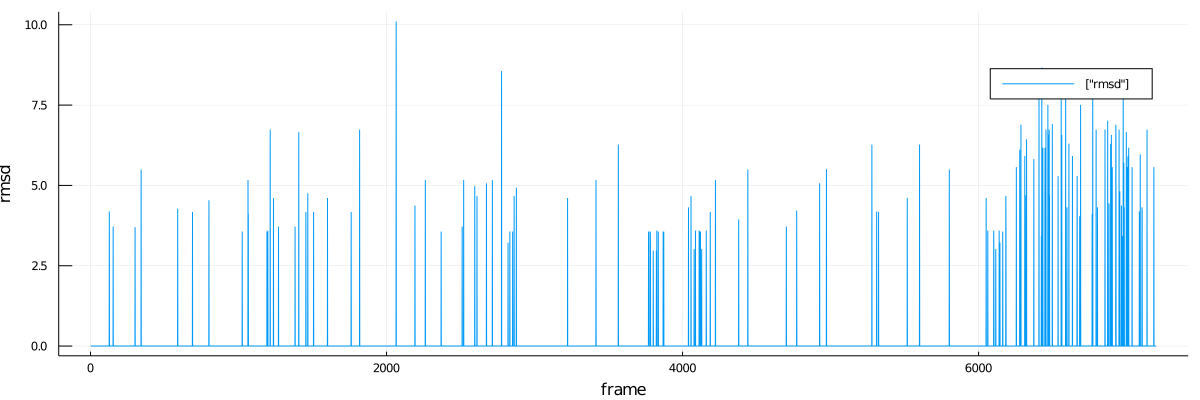

In [6]:
ok = 0
ng = 0
rmsds_default = []
for test_id in 1:test_num
    result = results_list[test_id]
    state_trans = state_trans_list[test_id]
    quate_trans = quate_trans_list[test_id]
    for frame_id in 1:size(result, 1)
        if result[frame_id].best_model_id == state_trans[frame_id]
            ok += 1
        else
            ng += 1
        end
        push!(rmsds_default, MDToolbox.compute_rmsd(model_array[result[frame_id].best_model_id, :], model_array[state_trans[frame_id], :])[1])
    end
end

println("ok is $ok")
println("ng is $ng")
println("rate is $(ok / (ok + ng))")

plot(1:size(rmsds_default, 1), rmsds_default, label = ["rmsd"], size=(1200, 400))
xlabel!("frame")
ylabel!("rmsd")

ok is 7056
ng is 144
rate is 0.98


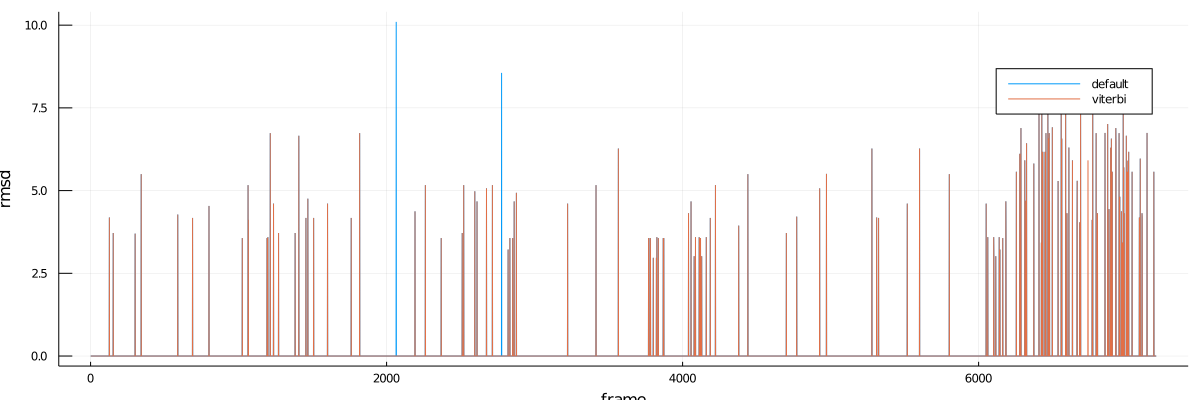

In [14]:
ok = 0
ng = 0
rmsds = []
for test_id in 1:test_num
    results = results_list[test_id]
    state_trans = state_trans_list[test_id]
    frame_num = size(results, 1)
    emission = zeros(Float64, model_num, frame_num)
    for frame_id in 1:frame_num
        emission[:, frame_id] .+= results[frame_id].posterior_results
        emission[:, frame_id] ./= sum(emission[:, frame_id])
    end
    state_estimated = msmviterbi(collect(1:frame_num), T, pi_i, emission)
    for frame_id in 1:frame_num
        if state_estimated[frame_id] == state_trans_list[test_id][frame_id]
            ok += 1
        else
            ng += 1
        end
        
        push!(rmsds, MDToolbox.compute_rmsd(model_array[state_estimated[frame_id], :], model_array[state_trans[frame_id], :])[1])
    end
end

println("ok is $ok")
println("ng is $ng")
println("rate is $(ok / (ok + ng))")

plot(1:size(rmsds_default, 1), [rmsds_default, rmsds], label = ["default" "viterbi"], size=(1200, 400))
xlabel!("frame")
ylabel!("rmsd")

ok is 7198
ng is 2
rate is 0.9997222222222222


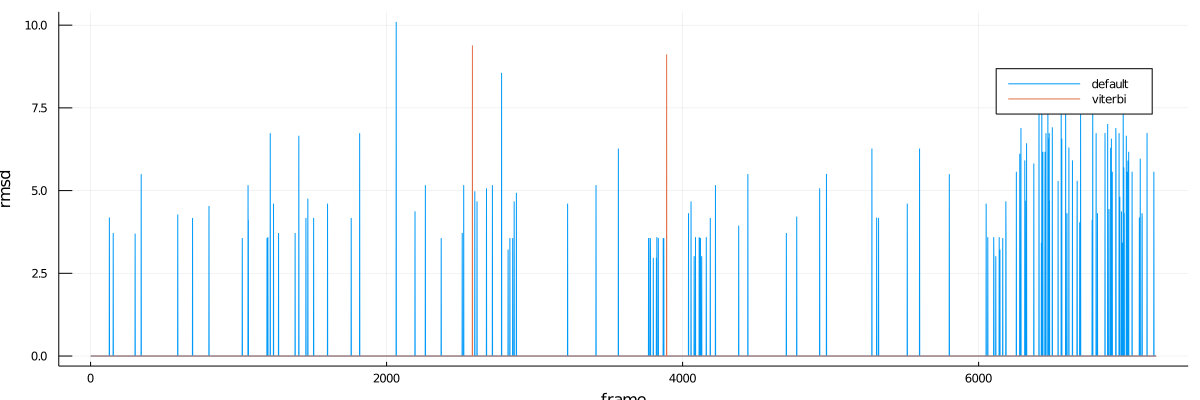

In [13]:
ok = 0
ng = 0
rmsds = []
for test_id in 1:test_num
    results = results_list[test_id]
    state_trans = state_trans_list[test_id]
    frame_num = size(results, 1)
    emission = zeros(Float64, model_num, model_num)
    for model_i in 1:model_num, model_j in 1:model_num
        emission[model_i, model_j] += 0.1 / model_num
        if model_i == model_j
            emission[model_i, model_j] += 0.9
        end
    end
    state_estimated = msmviterbi(state_trans_list[test_id], T, pi_i, emission)
    for frame_id in 1:frame_num
        if state_estimated[frame_id] == state_trans_list[test_id][frame_id]
            ok += 1
        else
            ng += 1
        end
        
        push!(rmsds, MDToolbox.compute_rmsd(model_array[state_estimated[frame_id], :], model_array[state_trans[frame_id], :])[1])
    end
end

println("ok is $ok")
println("ng is $ng")
println("rate is $(ok / (ok + ng))")

plot(1:size(rmsds_default, 1), [rmsds_default, rmsds], label = ["default" "viterbi"], size=(1200, 400))
xlabel!("frame")
ylabel!("rmsd")

 35.395522 seconds (55.43 M allocations: 32.810 GiB, 5.32% gc time)
ok is 7181
ng is 19
rate is 0.9973611111111111


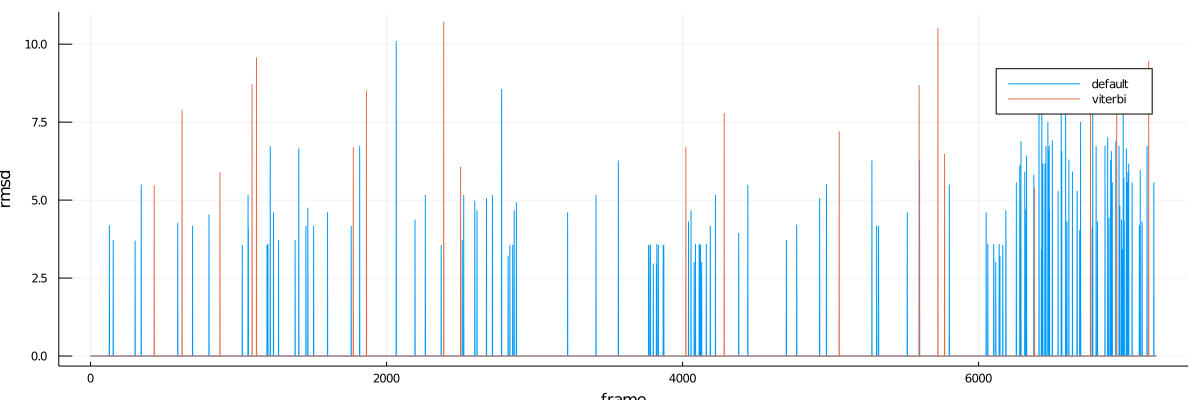

In [16]:
ok = 0
ng = 0
rmsds = []

emission = zeros(Float64, model_num, model_num)
for model_i in 1:model_num, model_j in 1:model_num
    emission[model_i, model_j] += 0.1 / model_num
    if model_i == model_j
        emission[model_i, model_j] += 0.9
    end
end
T0 = rand(Float64, model_num, model_num)
T0 .= T0 ./ sum(T0, dims=2)
@time T1, pi_i1, emission1 = msmbaumwelch(state_trans_list, T0, pi_i, emission)

for test_id in 1:test_num
    results = results_list[test_id]
    state_trans = state_trans_list[test_id]
    frame_num = size(results, 1)
    
    state_estimated = msmviterbi(state_trans_list[test_id], T1, pi_i, emission)
    for frame_id in 1:frame_num
        if state_estimated[frame_id] == state_trans_list[test_id][frame_id]
            ok += 1
        else
            ng += 1
        end
        
        push!(rmsds, MDToolbox.compute_rmsd(model_array[state_estimated[frame_id], :], model_array[state_trans[frame_id], :])[1])
    end
end

println("ok is $ok")
println("ng is $ng")
println("rate is $(ok / (ok + ng))")

plot(1:size(rmsds_default, 1), [rmsds_default, rmsds], label = ["default" "viterbi"], size=(1200, 400))
xlabel!("frame")
ylabel!("rmsd")

In [10]:
"""
ok = 0
ng = 0

quate_T = zeros(Float64, q_num, q_num)
quate_E = [[] for i in 1:q_num]
for i in 1:q_num
    arr = []
    for j in 1:q_num
        push!(arr, (quate_dist(q_array[i], q_array[j]), j))
    end
    sort!(arr)
    for id in 1:transitions_num
        quate_T[i, arr[id][2]] = 1 / transitions_num
        push!(quate_E[i], MDToolbox.Edge(arr[id][2], 1 / transitions_num))
    end
end

pi_quate_i = zeros(Float64, model_num * q_num)
for model_id in 1:model_num
    for q_id in 1:q_num
        pi_quate_i[(model_id - 1) * q_num + q_num] = pi_i[model_id]
    end
end

E = [[] for i in 1:(model_num * q_num)]
for model_i in 1:model_num, model_j in 1:model_num
    for q_i in 1:q_num
        for edge in quate_E[q_i]
            to = edge.to
            prob = T[model_i, model_j] * edge.value

            push!(E[(model_i - 1) * q_num + q_i], MDToolbox.Edge((model_j - 1) * q_num + to, prob)) 
        end
    end
end

for test_id in 1:test_num
    println("test_id: $test_id")
    results = results_list[test_id]
    frame_num = size(results, 1)
    emission = ones(Float64, model_num * q_num, frame_num) .* 0.01
    
    for frame_id in 1:frame_num
        for model_id in 1:model_num
            emission[(model_id - 1) * q_num + q_num, frame_id] += results[frame_id].posterior_results[model_id]
        end
    end
    
    state_estimated = MDToolbox.msmviterbi_edge(collect(1:frame_num), model_num * q_num, E, pi_quate_i, emission)
    for frame_id in 1:frame_num
        if div(state_estimated[frame_id] - 1, q_num) + 1 == state_trans_list[test_id][frame_id]
            ok += 1
        else
            ng += 1
        end
    end
end

println("ok is $ok")
println("ng is $ng")
println("rate is $(ok / (ok + ng))")
"""

UndefVarError: UndefVarError: test_id not defined